In [8]:
# 2018/04/25 Strichcoder: v0.2

import numpy as np
import random
import matplotlib.pyplot as plt

field=np.zeros((sizeX,sizeY))

NameError: name 'sizeX' is not defined

In [9]:
class Tetris:
    sizeX=8
    sizeY=8
    block=Block(0)
    # TODO: block_preview
    field=np.zeros((sizeX,sizeY))
    
    def __init__(self,sizeX=8,sizeY=8):
        self.sizeX=sizeX
        self.sizeY=sizeY
        self.field=np.zeros((sizeX,sizeY))
    
    # ------------------------- Game Logic ---------------------------------------
    
    # A new block is generated at the top of the field
    # Returns False, if it could not generate a block because of collision
    # TODO: if collision, place the block somewhere else at the top
    def next_block(self):
        s=random.randint(0,6)
        r=random.randint(0,3)
        self.block=Block(shape=s,rotation=r,posX=self.sizeX/2)
        if self.collides():
            self.block=None
            print('YOU LOST, could not generate any more blocks')
            return False
        else:
            return True
    
    # Requirements: move in {-1,0,1}, rotate in {-3,-2,-1,0,1,2,3}
    # first moves (if possible) then rotates (if possible)
    def interact(self,move=0,rotate=0): 
        self.block.posX+=move
        if self.collides():
            self.block.posX-=move
        self.block.rotation+=rotate
        self.block.rotation+=8
        self.block.rotation%=4
        if self.collides():
            self.block.rotation-=rotate
            self.block.rotation+=4
            self.block.rotation%=4
        
        
    # Tries to gravitate. 
    # Returns False, if it cannot gravitate. Then it permantently places the block in the field (place means field -= picture)
    #                then a new block is generated using next_block() and full rows are deleted.
    # Returns True, if it gravitates successfully (without colliding)
    def physics(self):
        self.block.posY+=1
        if self.collides():
            self.block.posY-=1
            picture=self.block.get_picture()
            offset=self.block.get_offset()
            x0=int(self.block.posX)-offset[0]
            y0=int(self.block.posY)-offset[1]
            self.field[x0:x0+picture.shape[0],y0:y0+picture.shape[1]]-=picture
            self.next_block()
            self.tidy()
            return False
        else:
            return True
        
    # full rows get delted
    # TODO: give points for it
    def tidy(self):
        for y in range(self.field.shape[1]):
            full=True
            for x in range(self.field.shape[0]):
                if not self.field[x,y]==-1:
                    full=False
            if full:
                print('totally full')
                self.field=np.delete(self.field,y,axis=1)
                self.field=np.insert(self.field,0,0,axis=1)
    
    # returns True, if picture.shape does not fit in the field
    # returns True, if the block overlaps a -1 in the field
    def collides(self):
        picture=self.block.get_picture()
        offset=self.block.get_offset()
        x0=int(self.block.posX)-offset[0]
        y0=int(self.block.posY)-offset[1]
        if x0<0 or y0<0 or x0+picture.shape[0] > self.field.shape[0] \
                        or y0+picture.shape[1] > self.field.shape[1]:
            return True
        else: # the picture is well defined
            for x in range(picture.shape[0]):
                for y in range(picture.shape[1]):
                    if picture[x,y]==1 and self.field[x0+x,y0+y]==-1:
                        return True
        return False
    
    # ----------------------------- Graphics ------------------------------------
    
    # returns a playing field with the block added (no collision detecting)
    # this may be used as input for the neural net.
    def project(self):
        picture=self.block.get_picture()
        offset=self.block.get_offset()
        x0=int(self.block.posX)-offset[0] # this is the coordinate in field where picture will be drawn
        y0=int(self.block.posY)-offset[1]
        print_field=np.copy(self.field)
        print_field[x0:x0+picture.shape[0],y0:y0+picture.shape[1]]+=picture
        return print_field
        
    # draws a nice picture :)
    def draw(self):
        plt.matshow(self.project().transpose())
        plt.show()
      

In [10]:
class Block:
    posX=0 # position of the 'center of rotation', to draw stuff, consider get_offset() too, 
    posY=0
    rotation=0 # 0, 1, 2, 3 mathematical rotation-direction
    shape=0 # 0 = square, 1 = bar, 2 = L, 3 = L', 4 = S, 5 = S', 6 = T
    
    def __init__(self,shape,rotation=0,posX=None,posY=None):
        self.shape=shape
        self.rotation = rotation
        if posX==None:
            self.posX=2
        else:
            self.posX=posX
        if posY==None: 
            self.posY=self.get_offset()[1] # position it at the top
        else:
            self.posY=posY
    
    # picture should have size exactly convex square hull.
    def get_picture(self):
        if self.shape==0: # square
            A=np.ones((2,2))
        if self.shape==1: # bar
            if self.rotation == 0 or self.rotation == 2:
                A=np.ones((1,4))
            if self.rotation == 1 or self.rotation == 3:
                A=np.ones((4,1))
        if self.shape==2: # L
            if self.rotation == 0: # I_ = L
                A=np.zeros((2,3))
                A[0,0]=1
                A[0,1]=1
                A[0,2]=1
                A[1,2]=1
            if self.rotation == 1: # __I
                A=np.zeros((3,2))
                A[0,1]=1
                A[1,1]=1
                A[2,0]=1
                A[2,1]=1
            if self.rotation == 2: # ^I
                A=np.zeros((2,3))
                A[0,0]=1
                A[1,0]=1
                A[1,1]=1
                A[1,2]=1
            if self.rotation == 3: # I^^
                A=np.zeros((3,2))
                A[0,0]=1
                A[0,1]=1
                A[1,0]=1
                A[2,0]=1
        if self.shape==3: # L' 
            if self.rotation == 0: # _I
                A=np.zeros((2,3))
                A[1,0]=1
                A[1,1]=1
                A[1,2]=1
                A[0,2]=1
            if self.rotation == 1: # ^^I
                A=np.zeros((3,2))
                A[0,0]=1
                A[1,0]=1
                A[2,0]=1
                A[2,1]=1
            if self.rotation == 2: # I^
                A=np.zeros((2,3))
                A[0,0]=1
                A[1,0]=1
                A[0,1]=1
                A[0,2]=1
            if self.rotation == 3: # I__
                A=np.zeros((3,2))
                A[0,0]=1
                A[0,1]=1
                A[1,1]=1
                A[2,1]=1
        if self.shape==4: # S
            if self.rotation == 0 or self.rotation == 2: 
                #  XX
                # XX 
                A=np.zeros((3,2))
                A[1,0]=1
                A[2,0]=1
                A[0,1]=1
                A[1,1]=1
            if self.rotation == 1 or self.rotation == 3: 
                # X
                # XX
                #  X
                A=np.zeros((2,3))
                A[0,0]=1
                A[0,1]=1
                A[1,1]=1
                A[1,2]=1
        if self.shape==5: # S'
            if self.rotation == 0 or self.rotation == 2: 
                # XX
                #  XX 
                A=np.zeros((3,2))
                A[0,0]=1
                A[1,0]=1
                A[1,1]=1
                A[2,1]=1
            if self.rotation == 1 or self.rotation == 3: 
                #  X
                # XX
                # X
                A=np.zeros((2,3))
                A[1,0]=1
                A[0,1]=1
                A[1,1]=1
                A[0,2]=1   
        if self.shape==6: # T
            if self.rotation == 0: # T
                A=np.zeros((3,2))
                A[0,0]=1
                A[1,0]=1
                A[2,0]=1
                A[1,1]=1
            if self.rotation == 1: # I-
                A=np.zeros((2,3))
                A[0,0]=1
                A[0,1]=1
                A[0,2]=1
                A[1,1]=1
            if self.rotation == 2: # _I_
                A=np.zeros((3,2))
                A[1,0]=1
                A[0,1]=1
                A[1,1]=1
                A[2,1]=1
            if self.rotation == 3: # -I
                A=np.zeros((2,3))
                A[0,1]=1
                A[1,0]=1
                A[1,1]=1
                A[1,2]=1
        return A
        
    def get_offset(self):
        if self.shape==0: # square
            return [0,0]
        if self.shape==1: # I
            if self.rotation == 0:
                return [0,1]
            if self.rotation == 1:
                return [1,0]
            if self.rotation == 2:
                return [0,2]
            if self.rotation == 3:
                return [2,0]
        if self.shape==2: # L
            if self.rotation == 0: # I_ = L
                return [0,2]
            if self.rotation == 1: # __I
                return [2,1]
            if self.rotation == 2: # ^I
                return [1,0]
            if self.rotation == 3: # I^^
                return [0,0]
        if self.shape==3: # L'
            if self.rotation == 0: # _I = L'
                return [1,2]
            if self.rotation == 1: # ^^I
                return [2,0]
            if self.rotation == 2: # I^
                return [0,0]
            if self.rotation == 3: # I__
                return [0,1]
        if self.shape == 4: # S
            if self.rotation == 0:
                return [1,1]
            if self.rotation == 1:
                return [1,1]
            if self.rotation == 2:
                return [1,0]
            if self.rotation == 3:
                return [0,1]
        if self.shape == 5: # S'
            if self.rotation == 0:
                return [1,1]
            if self.rotation == 1:
                return [1,1]
            if self.rotation == 2:
                return [1,0]
            if self.rotation == 3:
                return [0,1]
        if self.shape == 6: # T
            if self.rotation == 0: #T
                return [1,0]
            if self.rotation == 1: # I-
                return [0,1]
            if self.rotation == 2: # _I_
                return [1,1]
            if self.rotation == 3: # -I
                return [1,1]

    

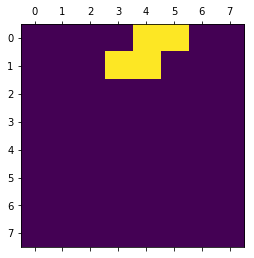

In [11]:
t=Tetris()
t.next_block()
t.project()
t.draw()

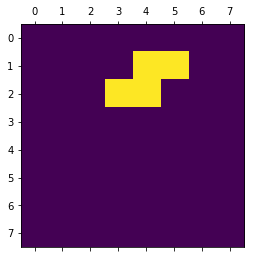

In [12]:
t.interact(move=0,rotate=0)
t.physics()
t.project()
t.draw()

Shape: 0 Rotation: 0


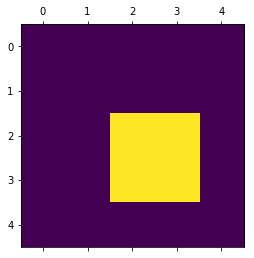

Shape: 0 Rotation: 1


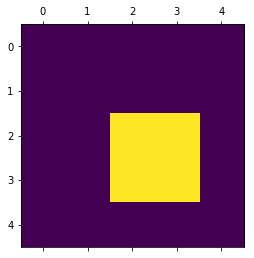

Shape: 0 Rotation: 2


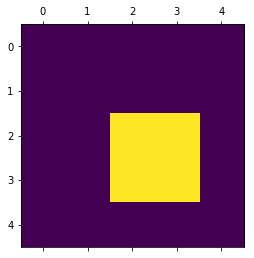

Shape: 0 Rotation: 3


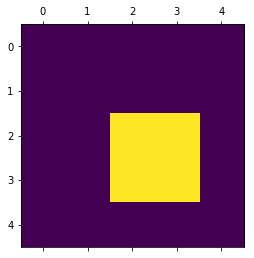

Shape: 1 Rotation: 0


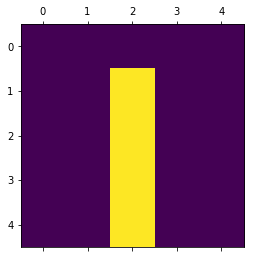

Shape: 1 Rotation: 1


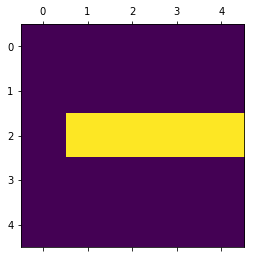

Shape: 1 Rotation: 2


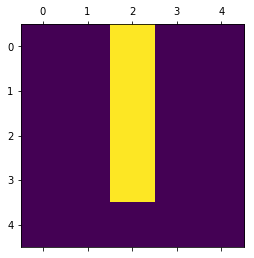

Shape: 1 Rotation: 3


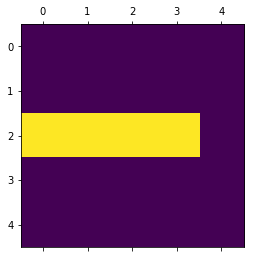

Shape: 2 Rotation: 0


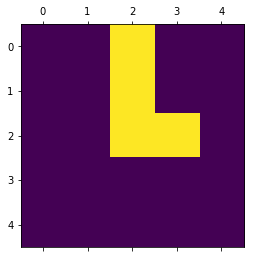

Shape: 2 Rotation: 1


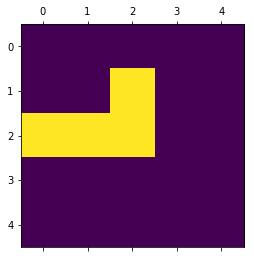

Shape: 2 Rotation: 2


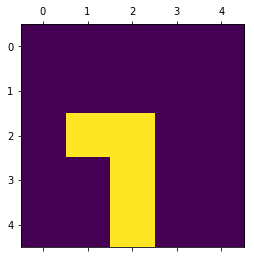

Shape: 2 Rotation: 3


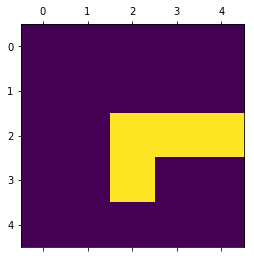

Shape: 3 Rotation: 0


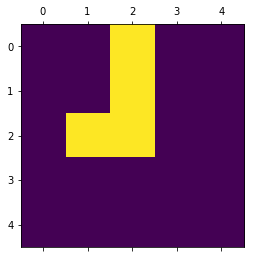

Shape: 3 Rotation: 1


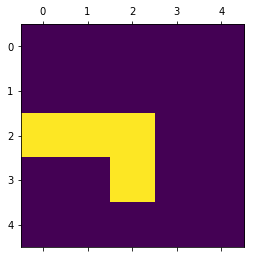

Shape: 3 Rotation: 2


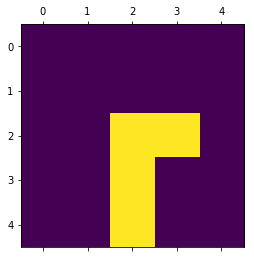

Shape: 3 Rotation: 3


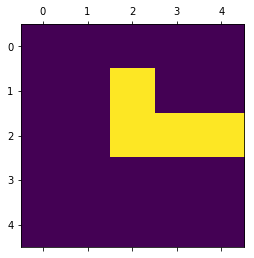

Shape: 4 Rotation: 0


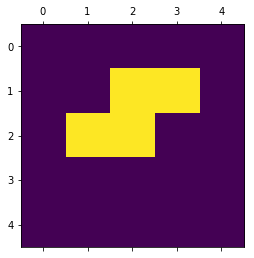

Shape: 4 Rotation: 1


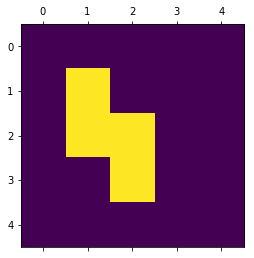

Shape: 4 Rotation: 2


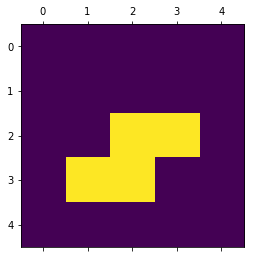

Shape: 4 Rotation: 3


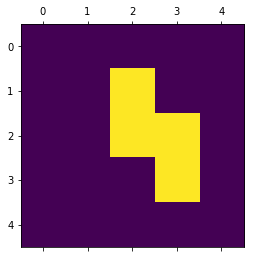

Shape: 5 Rotation: 0


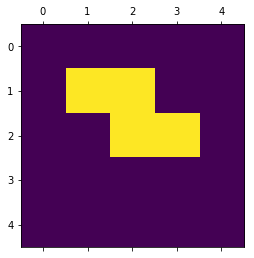

Shape: 5 Rotation: 1


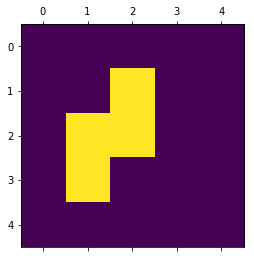

Shape: 5 Rotation: 2


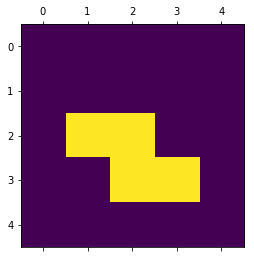

Shape: 5 Rotation: 3


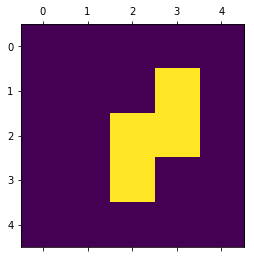

Shape: 6 Rotation: 0


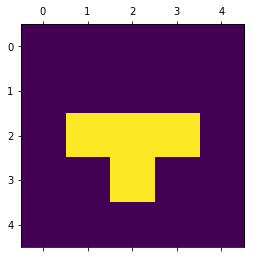

Shape: 6 Rotation: 1


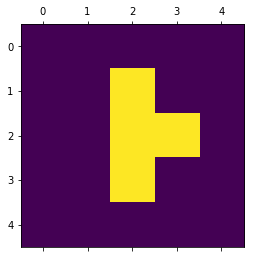

Shape: 6 Rotation: 2


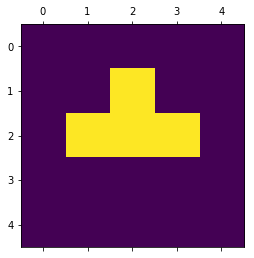

Shape: 6 Rotation: 3


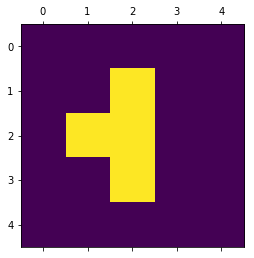

In [21]:
# Test wheter all the shapes are correct and rotate correctly.
t=Tetris()
for s in range(7):
    b=Block(s)
    b.posX = 2
    b.posY = 2
    for r in range(4):
        b.rotation = r
        t.field=np.zeros((5,5))
        t.block=b
        print('Shape:',s,'Rotation:',r)
        t.draw()  


In [7]:
# I tried installing this but failed. :/
import tensorflow as tf
>>> hello = tf.constant('Hello, TensorFlow!')
>>> sess = tf.Session()
>>> print(sess.run(hello))


ModuleNotFoundError: No module named 'tensorflow'